# Portfolio Workflow

In [1]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np



from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

# Set the import path for the tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, '../tools')
import importlib
import ameritrade_functions as amc
importlib.reload(amc)
import trading_factors_yahoo as alpha_factors
importlib.reload(alpha_factors)
import utils
importlib.reload(utils)
import nonoverlapping_estimator as ai_estimator
importlib.reload(ai_estimator)

print(f'Python version: {python_version()}')
print(f'Pandas version: {pd.__version__}')
print()

Sci-Kit version: 0.24.1
Sci-Kit version: 0.24.1
Python version: 3.8.8
Pandas version: 1.3.5



In [2]:
# For Chromedriver
from pathlib import Path

# Make sure we have a data directory
Path('./data').mkdir(parents=True, exist_ok=True) 

# Which account are we interested in
masked_account_number = '#---5311'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

# Stage 4a: Demonstrate using AI Alpha and Daily Betas to produce optimal weights

In [16]:
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
print(f'Date range for price histories: {price_histories.index.min()} to {price_histories.index.max()}')
pricing = price_histories.Close
print(f'You have {len(pricing.columns)} stocks from picing')

alpha_vectors = pd.read_csv('data/alpha_vectors.csv', parse_dates=['Date']).set_index(['Date']).sort_index()
print(f'You have {len(alpha_vectors.columns)} stocks from alpha')

with open('data/daily_beta.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    daily_betas = pickle.load(f)
print(f'You have {len(daily_betas)} of daily betas')

Date range for price histories: 2017-04-20 00:00:00 to 2022-04-18 00:00:00
You have 424 stocks from picing
You have 300 stocks from alpha
You have 1008 of daily betas


## Generate Daily Optimal Portfolios using 1 year of alpha and beta

This first strategy is to use 2 day returns and optimize the portfolio daily.

The second stragety is to use last day of the month returns and to optimize the portfolio monthly (or 20 day returns).

Start with the last date, subtract 1 year to get the start and end dates for the betas.

In [21]:
import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
importlib.reload(portfolio_optimizer)

risk_cap = 0.30
weights_max = 0.5
weights_min = 0.00

## 5 Day Strategy Backtest

Use 5 Day returns and optimize portfolio weekly. 

We are looking for something at 8% return or better

In [22]:
returns = alpha_factors.FactorReturns(price_histories).factor_data
dlyreturn_n_days_delay = forward_prediciton_days
delayed_returns = returns[-252:].shift(-dlyreturn_n_days_delay).dropna()
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
print(f'Generating 1 year Optimal Portfolios from {start_date} to {end_date}')
current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
init_port_value = portfolio_value = 100000
portfolio_growth = {}
for opt_date in tqdm(delayed_returns.index.to_list()[-252::dlyreturn_n_days_delay], desc='Dates', unit='Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
    long_holdings = (long_weights['optimalWeights'] * portfolio_value).round(0)
    new_holdings = long_holdings + (long_holdings * est_return[long_holdings.index])
    portfolio_value = new_holdings.sum()
    portfolio_growth[opt_date] = portfolio_value
    current_holdings = new_holdings

Generating 1 year Optimal Portfolios from 2021-04-20 00:00:00 to 2022-04-08 00:00:00


Dates:   0%|          | 0/50 [00:00<?, ?Portfolio Optimization/s]

<AxesSubplot:>

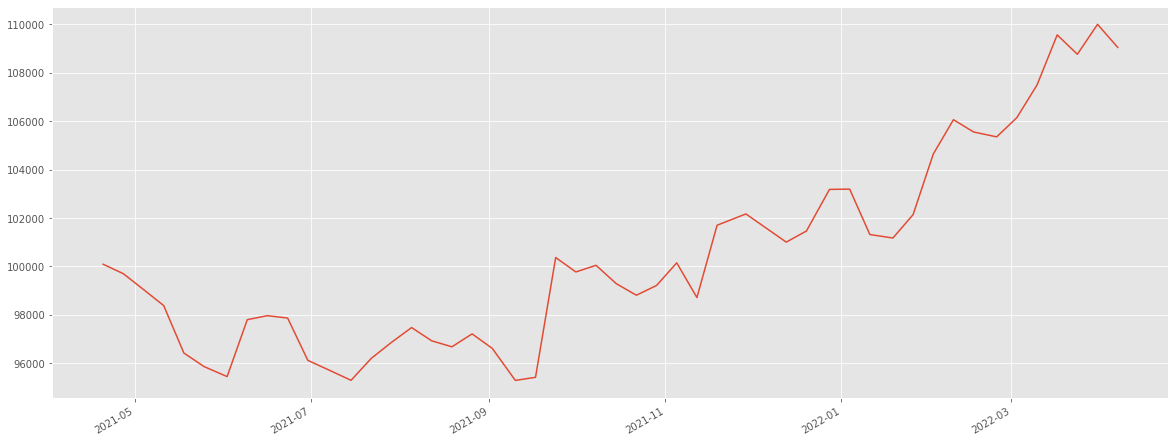

In [23]:
pd.Series(portfolio_growth).plot()

In [24]:
port_return = round(np.log(portfolio_value / init_port_value) * 100, 2)
print(f'Starting portfolio: {init_port_value} Ending portfolio: {portfolio_value} Return: {port_return}%')
if port_return >= 8:
    print('Backtest indicates its okay to proceed with this strategy.')
else:
    raise RuntimeError(f'Backtest indicates this strategy needs more work! ({port_return})') from None

Starting portfolio: 100000 Ending portfolio: 109051.78221619481 Return: 8.67%
Backtest indicates its okay to proceed with this strategy.


## Use the last week to determine current portfolio mix

In [116]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('IRAHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['IRA']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

In [68]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
print(f'You have {len(alpha_vectors.columns)} stocks from alpha')

with open(beta_factors_file_name, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    daily_betas = pickle.load(f)
print(f'You have {len(daily_betas)} of daily betas')

You have 501 stocks from alpha
You have 1008 of daily betas


In [69]:
risk_cap = float(config['BackTest']['risk_cap'])
weights_max = float(config['BackTest']['weights_max'])
weights_min = float(config['BackTest']['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

In [70]:
alpha_vectors.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-11,0.011807,0.011050,0.003622,-0.016394,-0.014645,-0.022380,0.011923,0.011645,-0.022380,-0.009534,...,0.012121,0.010102,-0.012622,0.002938,-0.008142,0.007760,-0.016864,0.010896,0.007312,0.008034
2018-04-12,0.011643,0.012143,0.003192,-0.016262,-0.015309,-0.022787,0.012025,0.011356,-0.022787,-0.011193,...,0.012363,0.004616,-0.010925,0.004561,-0.011539,0.010939,-0.016753,0.010452,0.007603,0.010256
2018-04-13,0.011176,0.011491,-0.000494,-0.014361,-0.012971,-0.022161,0.011840,0.010770,-0.016879,-0.001268,...,0.011840,-0.003116,-0.006867,0.005159,-0.013065,0.010318,-0.015095,0.010356,0.005888,0.010710
2018-04-16,0.010784,0.011096,0.000307,-0.014079,-0.010710,-0.022102,0.011387,0.011135,-0.014000,0.003594,...,0.011387,-0.009856,-0.001227,0.005052,-0.013011,0.011308,-0.014114,0.010542,0.003446,0.010629
2018-04-17,0.010526,0.010849,0.002491,-0.013579,-0.002247,-0.021737,0.010849,0.009820,-0.013648,0.010130,...,0.010849,-0.012623,0.002553,0.002894,-0.012526,0.011046,-0.013612,0.010167,0.003606,0.010376


In [71]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

In [72]:
len(reduced_stocks)

426

In [73]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]

In [74]:
final_alhpa_vectors.head()

,A,AAP,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,...,WST,WTW,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-11,0.011807,0.003622,-0.014645,-0.022380,0.011923,0.011645,-0.022380,-0.009534,-0.011548,-0.010835,...,-0.013400,-0.022380,0.012121,0.010102,-0.012622,-0.008142,0.007760,-0.016864,0.010896,0.008034
2018-04-12,0.011643,0.003192,-0.015309,-0.022787,0.012025,0.011356,-0.022787,-0.011193,-0.008807,-0.007269,...,-0.011814,-0.018819,0.012363,0.004616,-0.010925,-0.011539,0.010939,-0.016753,0.010452,0.010256
2018-04-13,0.011176,-0.000494,-0.012971,-0.022161,0.011840,0.010770,-0.016879,-0.001268,0.001531,-0.004987,...,-0.009508,-0.018637,0.011840,-0.003116,-0.006867,-0.013065,0.010318,-0.015095,0.010356,0.010710
2018-04-16,0.010784,0.000307,-0.010710,-0.022102,0.011387,0.011135,-0.014000,0.003594,0.002857,0.001243,...,-0.005798,-0.017634,0.011387,-0.009856,-0.001227,-0.013011,0.011308,-0.014114,0.010542,0.010629
2018-04-17,0.010526,0.002491,-0.002247,-0.021737,0.010849,0.009820,-0.013648,0.010130,0.003811,0.002881,...,-0.005652,-0.015871,0.010849,-0.012623,0.002553,-0.012526,0.011046,-0.013612,0.010167,0.010376


In [75]:
opt_date = final_alhpa_vectors.index[-1]
print(f'From date: {opt_date}')
risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]

From date: 2022-10-14 00:00:00


In [76]:
risk_model.factor_betas_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
MMM,-0.028937,-0.011365,-0.034147,0.047220,0.037320,0.021107,-0.004487,0.027043,-0.008108,-0.017651,-0.018250,0.028194,0.036028,0.024429,-0.039249,-0.071342,0.006332,0.008762,-0.014778,0.000196
AOS,-0.040304,0.006346,-0.036029,0.025397,0.057450,0.046039,-0.011832,-0.002475,-0.045466,0.025994,0.013597,-0.001828,0.028439,0.020594,-0.025840,-0.059460,-0.017911,-0.071197,-0.011780,0.017160
ABT,-0.032575,0.008612,-0.054563,0.007963,-0.008847,-0.044131,-0.033429,-0.013865,0.037195,-0.025336,0.030437,0.004675,0.003951,0.016279,0.002353,-0.016760,0.006128,-0.023680,0.022993,0.030251
ABBV,-0.013665,-0.020370,-0.047732,0.024904,-0.013600,-0.022936,-0.005688,-0.014054,0.053724,-0.047877,-0.001775,-0.012008,-0.017143,-0.045816,0.052500,-0.082350,0.031572,0.000289,0.004552,0.004302
ABMD,-0.064987,0.037682,-0.008640,-0.047230,-0.056010,-0.031333,0.017135,-0.042890,0.067845,-0.022185,0.113854,0.033958,-0.003257,-0.026045,0.020454,-0.013200,0.091526,-0.082388,-0.008189,-0.005333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,-0.033077,0.006400,-0.015407,0.008793,-0.011712,-0.015258,0.029180,-0.016864,-0.018461,-0.000461,0.001656,0.019478,-0.000161,-0.010882,0.053364,0.017004,-0.029864,0.011292,0.006816,-0.018768
ZBRA,-0.062841,0.034036,-0.007953,-0.029463,0.052509,0.015125,0.015163,-0.017709,0.001809,-0.043879,-0.035590,0.011818,-0.001408,0.022383,-0.029460,0.001038,-0.047920,-0.068795,0.028263,0.008490
ZBH,-0.038251,-0.013201,-0.008350,0.022328,-0.049376,-0.026193,-0.021086,0.011213,0.028063,0.011392,0.061498,0.059379,0.021496,-0.032606,-0.000749,-0.062661,0.012457,0.014430,-0.031331,-0.046427
ZION,-0.048619,-0.045793,0.034747,0.060946,0.057104,-0.042186,-0.067676,0.033420,0.048412,0.073223,-0.028175,0.005797,-0.002259,0.021781,0.060502,0.037994,0.065212,-0.017152,-0.028329,-0.020172


In [77]:
risk_model.factor_betas_ = risk_model.factor_betas_.loc[final_alhpa_vectors.columns]
risk_model.factor_betas_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
A,-0.044946,0.033067,-0.045294,-0.031748,0.004026,-0.058043,-0.027063,-0.052414,-0.000992,-0.008821,0.053573,-0.007950,0.006311,0.030840,-0.013263,-0.008410,0.006723,-0.007524,0.032235,0.003641
AAP,-0.038513,-0.008294,-0.032463,0.030086,0.034417,0.107151,0.027753,-0.022380,-0.013541,0.032638,0.017415,-0.066433,-0.004188,-0.096688,0.069523,0.006308,-0.039034,-0.017732,-0.023516,0.032498
ABBV,-0.013665,-0.020370,-0.047732,0.024904,-0.013600,-0.022936,-0.005688,-0.014054,0.053724,-0.047877,-0.001775,-0.012008,-0.017143,-0.045816,0.052500,-0.082350,0.031572,0.000289,0.004552,0.004302
ABC,-0.022489,-0.041128,-0.041116,0.018734,-0.019031,-0.012950,0.012231,0.001473,0.038651,-0.009849,0.002790,-0.017421,0.040953,-0.055580,0.035170,-0.022068,0.016197,0.068836,0.033653,0.015624
ABMD,-0.064987,0.037682,-0.008640,-0.047230,-0.056010,-0.031333,0.017135,-0.042890,0.067845,-0.022185,0.113854,0.033958,-0.003257,-0.026045,0.020454,-0.013200,0.091526,-0.082388,-0.008189,-0.005333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,-0.048245,0.020434,-0.038071,0.009905,0.027857,0.001818,0.018039,-0.010640,-0.052870,0.047485,-0.038809,0.034048,0.010447,0.026309,-0.034462,-0.081224,0.017111,-0.032779,-0.053893,0.023186
YUM,-0.033077,0.006400,-0.015407,0.008793,-0.011712,-0.015258,0.029180,-0.016864,-0.018461,-0.000461,0.001656,0.019478,-0.000161,-0.010882,0.053364,0.017004,-0.029864,0.011292,0.006816,-0.018768
ZBH,-0.038251,-0.013201,-0.008350,0.022328,-0.049376,-0.026193,-0.021086,0.011213,0.028063,0.011392,0.061498,0.059379,0.021496,-0.032606,-0.000749,-0.062661,0.012457,0.014430,-0.031331,-0.046427
ZBRA,-0.062841,0.034036,-0.007953,-0.029463,0.052509,0.015125,0.015163,-0.017709,0.001809,-0.043879,-0.035590,0.011818,-0.001408,0.022383,-0.029460,0.001038,-0.047920,-0.068795,0.028263,0.008490


In [78]:
risk_model.idiosyncratic_var_vector_ = risk_model.idiosyncratic_var_vector_.loc[final_alhpa_vectors.columns]
risk_model.idiosyncratic_var_vector_

,0
A,0.000119
AAP,0.000162
ABBV,0.000094
ABC,0.000077
ABMD,0.000249
...,...
XYL,0.000113
YUM,0.000082
ZBH,0.000160
ZBRA,0.000181


In [79]:
risk_model.idiosyncratic_var_matrix_ = risk_model.idiosyncratic_var_matrix_.loc[final_alhpa_vectors.columns]
risk_model.idiosyncratic_var_matrix_ = risk_model.idiosyncratic_var_matrix_[final_alhpa_vectors.columns]
risk_model.idiosyncratic_var_matrix_

Symbols,A,AAP,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,...,WST,WTW,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
A,0.000119,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
AAP,0.000000,0.000162,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
ABBV,0.000000,0.000000,0.000094,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
ABC,0.000000,0.000000,0.000000,0.000077,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
ABMD,0.000000,0.000000,0.000000,0.000000,0.000249,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000113,0.000000,0.00000,0.000000,0.000000
YUM,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000082,0.00000,0.000000,0.000000
ZBH,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00016,0.000000,0.000000
ZBRA,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000181,0.000000


In [80]:
opt_date = alpha_vectors.index[-1]
print(f'From date: {opt_date}')
risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

From date: 2022-10-14 00:00:00


New portfolio variance is:  0.01589216


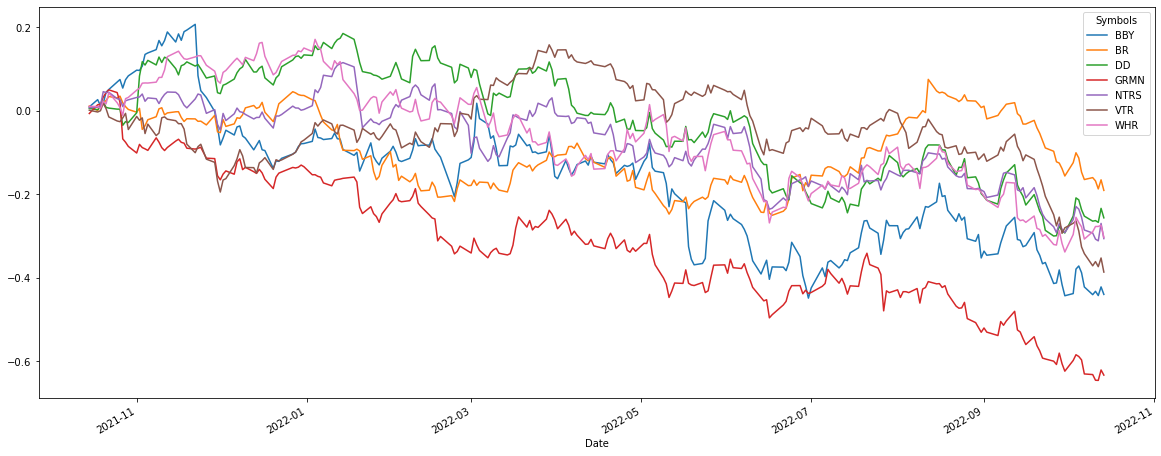

In [81]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [82]:
long_weights

,optimalWeights
BBY,0.15
BR,0.15
DD,0.15
GRMN,0.10
NTRS,0.15
VTR,0.15
WHR,0.15


In [83]:
import ameritrade_functions as amc
import utils

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.get_fundamental(list(long_weights.index.to_list()))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,11133T103,BR,"Broadridge Financial Solutions, Inc. Common Stock",NYSE,EQUITY,185.400,132.400,2.90,2.08,2022-09-14 00:00:00.000,...,13.68304,0.0,0.0,0.0,0.725,2022-10-05 00:00:00.000,0.95874,634630.0,634629.0,11475920.0
1,26614N102,DD,"DuPont de Nemours, Inc. Common Stock",NYSE,EQUITY,85.160,49.520,1.32,2.53,2022-07-28 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.330,2022-09-15 00:00:00.000,1.40187,2983510.0,2983508.0,59875940.0
2,963320106,WHR,Whirlpool Corporation Common Stock,NYSE,EQUITY,245.440,134.680,7.00,5.03,2022-08-25 00:00:00.000,...,4.95287,0.0,0.0,0.0,1.750,2022-09-15 00:00:00.000,1.56025,597200.0,597201.0,16663780.0
3,665859104,NTRS,Northern Trust Corporation - Common Stock,NASDAQ,EQUITY,135.150,81.890,3.00,3.57,2022-09-08 00:00:00.000,...,6.23789,0.0,0.0,0.0,0.750,2022-10-01 00:00:00.000,1.11760,920620.0,920616.0,19737400.0
4,92276F100,VTR,"Ventas, Inc. Common Stock",NYSE,EQUITY,64.020,35.330,1.80,4.99,2022-09-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.450,2022-10-14 00:00:00.000,1.20422,2627720.0,2627724.0,41986600.0
5,086516101,BBY,"Best Buy Co., Inc. Common Stock",NYSE,EQUITY,141.970,60.785,3.52,5.56,2022-09-19 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.880,2022-10-11 00:00:00.000,1.49243,2287460.0,2287461.0,59752350.0
6,H2906T109,GRMN,Garmin Ltd. Common Stock (Switzerland),NYSE,EQUITY,165.835,76.370,2.92,3.68,2022-12-14 00:00:00.000,...,11.85881,0.0,0.0,0.0,0.730,2022-12-30 00:00:00.000,0.97784,969440.0,969436.0,21720530.0


Tickers:   0%|          | 0/7 [00:02<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/7 [00:00<?, ?News Table Items/s]

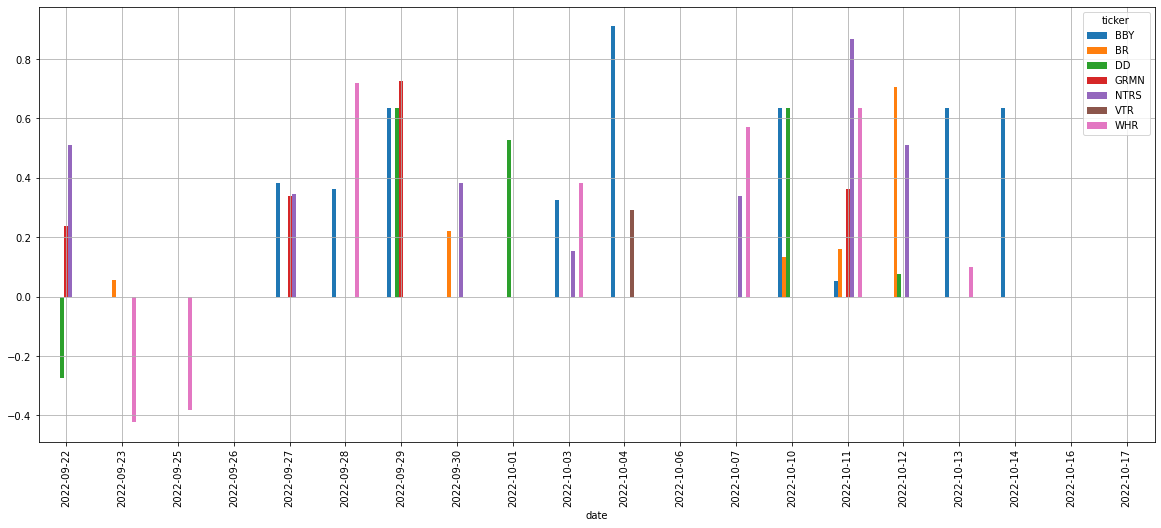

In [84]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

In [85]:
mean_scores

ticker,BBY,BR,DD,GRMN,NTRS,VTR,WHR
date,,,,,,,
2021-11-18,NaN,NaN,NaN,NaN,NaN,-0.5574,NaN
2021-11-19,NaN,NaN,NaN,NaN,NaN,0.0000,NaN
2021-12-01,NaN,NaN,NaN,NaN,NaN,0.0000,NaN
2021-12-07,NaN,NaN,NaN,NaN,NaN,0.2960,NaN
2021-12-10,NaN,NaN,NaN,NaN,NaN,-0.3182,NaN
...,...,...,...,...,...,...,...
2022-10-12,NaN,0.7071,0.0772,0.0,0.5106,NaN,NaN
2022-10-13,0.6369,NaN,NaN,NaN,0.0000,NaN,0.100475
2022-10-14,0.6369,NaN,NaN,NaN,0.0000,NaN,NaN


## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [91]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

print(f'Date of trade: {datetime.today()}')

# Specific Portfolio Account
account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
print('Full Equity Portfolio:')
display(equity_investments_df)



You have authorization
Date of trade: 2022-10-17 09:59:06.133104
Full Equity Portfolio:


,account,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,symbol,description,type
14,#---5311,0.0,35.56279,0.0,45.111372,2.64,60.707,60.707,0.0,1752.19,1752.19,60.707,EQUITY,808524805,SCHF,0,0
15,#---5311,0.0,52.14316,0.0,9.752341,0.29,71.973,71.973,0.0,3428.47,3428.47,71.973,EQUITY,922020805,VTIP,0,0
16,#---5311,0.0,56.70503,0.0,138.600000,2.49,165.000,165.000,0.0,5702.40,5702.40,165.000,EQUITY,958102105,WDC,0,0
17,#---5311,0.0,59.10313,0.0,58.198500,3.49,35.925,35.925,0.0,1724.76,1724.76,35.925,EQUITY,922042874,VGK,0,0
18,#---5311,0.0,40.44691,0.0,13.224000,2.26,13.224,13.224,0.0,597.86,597.86,13.224,EQUITY,316092501,FNCL,0,0
19,#---5311,0.0,94.94904,0.0,167.783253,2.09,95.467,95.467,0.0,8195.60,8195.60,95.467,EQUITY,929740108,WAB,0,0
20,#---5311,0.0,30.81202,0.0,18.433980,2.47,34.137,34.137,0.0,763.99,763.99,34.137,EQUITY,808524706,SCHE,0,0
21,#---5311,0.0,42.61006,0.0,2.747520,1.33,5.088,5.088,0.0,209.78,209.78,5.088,EQUITY,316092303,FSTA,0,0
22,#---5311,0.0,362.82111,0.0,151.319780,2.62,25.178,25.178,0.0,5936.47,5936.47,25.178,EQUITY,57060D108,MKTX,0,0
23,#---5311,0.0,77.86802,0.0,33.114912,2.67,20.291,20.291,0.0,1271.88,1271.88,20.291,EQUITY,808524508,SCHM,0,0


Stocks to sell:


,account,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,symbol,description,type
14,#---5311,0.0,35.56279,0.0,45.111372,2.64,60.707,60.707,0.0,1752.19,1752.19,60.707,EQUITY,808524805,SCHF,0,0
16,#---5311,0.0,56.70503,0.0,138.600000,2.49,165.000,165.000,0.0,5702.40,5702.40,165.000,EQUITY,958102105,WDC,0,0
17,#---5311,0.0,59.10313,0.0,58.198500,3.49,35.925,35.925,0.0,1724.76,1724.76,35.925,EQUITY,922042874,VGK,0,0
18,#---5311,0.0,40.44691,0.0,13.224000,2.26,13.224,13.224,0.0,597.86,597.86,13.224,EQUITY,316092501,FNCL,0,0
19,#---5311,0.0,94.94904,0.0,167.783253,2.09,95.467,95.467,0.0,8195.60,8195.60,95.467,EQUITY,929740108,WAB,0,0
20,#---5311,0.0,30.81202,0.0,18.433980,2.47,34.137,34.137,0.0,763.99,763.99,34.137,EQUITY,808524706,SCHE,0,0
21,#---5311,0.0,42.61006,0.0,2.747520,1.33,5.088,5.088,0.0,209.78,209.78,5.088,EQUITY,316092303,FSTA,0,0
22,#---5311,0.0,362.82111,0.0,151.319780,2.62,25.178,25.178,0.0,5936.47,5936.47,25.178,EQUITY,57060D108,MKTX,0,0
23,#---5311,0.0,77.86802,0.0,33.114912,2.67,20.291,20.291,0.0,1271.88,1271.88,20.291,EQUITY,808524508,SCHM,0,0
27,#---5311,0.0,169.07886,0.0,11.571560,2.53,3.094,3.094,0.0,468.59,468.59,3.094,EQUITY,922908611,VBR,0,0


In [100]:
long_term_stocks = default_config['long_term_stocks'].split()

# Filter out non Equity investments
current_stocks = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(
    utils.get_investment_symbols(equity_investments_df)).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df['symbol'].isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell['symbol'].isin(long_term_stocks)]
print('Stocks to sell:')
stocks_to_sell

Stocks to sell:


,account,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,symbol,description,type
16,#---5311,0.0,56.70503,0.0,138.600000,2.49,165.000,165.000,0.0,5702.40,5702.40,165.000,EQUITY,958102105,WDC,0,0
19,#---5311,0.0,94.94904,0.0,167.783253,2.09,95.467,95.467,0.0,8195.60,8195.60,95.467,EQUITY,929740108,WAB,0,0
22,#---5311,0.0,362.82111,0.0,151.319780,2.62,25.178,25.178,0.0,5936.47,5936.47,25.178,EQUITY,57060D108,MKTX,0,0


In [101]:
td_ameritrade.get_fundamental(list(stocks_to_sell.symbol.to_list()))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,57060D108,MKTX,"MarketAxess Holdings, Inc. - Common Stock",NASDAQ,EQUITY,424.035,217.440,2.8,1.22,2022-08-02 00:00:00.000,...,17.11180,0.0,0.0,0.0,0.70,2022-08-17 00:00:00.000,0.64908,296260.0,296255.0,7499460.0
1,958102105,WDC,Western Digital Corporation - Common Stock,NASDAQ,EQUITY,69.360,31.561,0.0,0.00,,...,0.00000,0.0,0.0,0.0,0.50,2020-04-17 00:00:00.000,1.54860,6605250.0,6605252.0,90164630.0
2,929740108,WAB,Westinghouse Air Brake Technologies Corporatio...,NYSE,EQUITY,100.045,78.260,0.6,0.71,2022-08-12 00:00:00.000,...,18.88636,0.0,0.0,0.0,0.15,2022-08-29 00:00:00.000,1.47090,744180.0,744177.0,17323580.0


In [102]:
account_portfolio_df

,account,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,symbol,description,type
14,#---5311,0.0,35.562790,0.0,45.111372,2.64,60.707,60.707,0.0,1752.19,1752.19,60.707,EQUITY,808524805,SCHF,0,0
15,#---5311,0.0,52.143160,0.0,9.752341,0.29,71.973,71.973,0.0,3428.47,3428.47,71.973,EQUITY,922020805,VTIP,0,0
16,#---5311,0.0,56.705030,0.0,138.600000,2.49,165.000,165.000,0.0,5702.40,5702.40,165.000,EQUITY,958102105,WDC,0,0
17,#---5311,0.0,59.103130,0.0,58.198500,3.49,35.925,35.925,0.0,1724.76,1724.76,35.925,EQUITY,922042874,VGK,0,0
18,#---5311,0.0,40.446910,0.0,13.224000,2.26,13.224,13.224,0.0,597.86,597.86,13.224,EQUITY,316092501,FNCL,0,0
19,#---5311,0.0,94.949040,0.0,167.783253,2.09,95.467,95.467,0.0,8195.60,8195.60,95.467,EQUITY,929740108,WAB,0,0
20,#---5311,0.0,30.812020,0.0,18.433980,2.47,34.137,34.137,0.0,763.99,763.99,34.137,EQUITY,808524706,SCHE,0,0
21,#---5311,0.0,42.610060,0.0,2.747520,1.33,5.088,5.088,0.0,209.78,209.78,5.088,EQUITY,316092303,FSTA,0,0
22,#---5311,0.0,362.821110,0.0,151.319780,2.62,25.178,25.178,0.0,5936.47,5936.47,25.178,EQUITY,57060D108,MKTX,0,0
23,#---5311,0.0,77.868020,0.0,33.114912,2.67,20.291,20.291,0.0,1271.88,1271.88,20.291,EQUITY,808524508,SCHM,0,0


In [103]:
stocks_to_sell.sum(axis=0)

account                              #---5311#---5311#---5311
shortQuantity                                             0.0
averagePrice                                        514.47518
currentDayCost                                            0.0
currentDayProfitLoss                               457.703033
currentDayProfitLossPercentage                            7.2
longQuantity                                          285.645
settledLongQuantity                                   285.645
settledShortQuantity                                      0.0
marketValue                                          19834.47
maintenanceRequirement                               19834.47
previousSessionLongQuantity                           285.645
assetType                                  EQUITYEQUITYEQUITY
cusip                             95810210592974010857060D108
symbol                                             WDCWABMKTX
description                                                 0
type    

### Submit and montior sell orders

In [104]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

Placing SELL order on #---5311 for 165.0 shares of WDC...
Placed SELL order on #---5311 for 165.0 shares of WDC
Placing SELL order on #---5311 for 95.467 shares of WAB...
Placed SELL order on #---5311 for 95.467 shares of WAB
Placing SELL order on #---5311 for 25.178 shares of MKTX...
Placed SELL order on #---5311 for 25.178 shares of MKTX


In [113]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    print(f'\r{datetime.today()} - Stocks to sell: {stocks_with_sell_orders.symbol.values}', end='           ')
    time.sleep(60)
    
print(f'\r{datetime.today()} - All stocks sold: {stocks_to_sell.symbol.values}')

2022-10-17 10:50:25.277290 - All stocks sold: ['WDC' 'WAB' 'MKTX']          


In [114]:
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
print(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
print(f'Total cash to invest: {available_cash}')

initialBalances_cashBalance            0.000000
initialBalances_totalCash              0.000000
initialBalances_equity             83232.240000
initialBalances_moneyMarketFund     1143.330000
currentBalances_cashBalance        19612.470000
currentBalances_equity             85222.810000
currentBalances_moneyMarketFund     1143.330000
current_return                         0.023634
Name: #---5311, dtype: float64
19612.47
1143.33
Total cash to invest: 20755.800000000003


In [117]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 20755.800000000003
Amount to invest: 20000


In [118]:
long_weights

,optimalWeights
BBY,0.15
BR,0.15
DD,0.15
GRMN,0.10
NTRS,0.15
VTR,0.15
WHR,0.15


In [119]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-10-17 10:51:53.659057
Initial investment amount: 20000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
BBY,65.750,0.15,3000.0,45
BR,142.640,0.15,3000.0,21
DD,53.510,0.15,3000.0,56
GRMN,81.485,0.10,2000.0,24
NTRS,86.870,0.15,3000.0,34
VTR,37.420,0.15,3000.0,80
WHR,141.510,0.15,3000.0,21


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
BBY,65.750,0.15,3000.0,45,2958.75
BR,142.640,0.15,3000.0,21,2995.44
DD,53.510,0.15,3000.0,56,2996.56
GRMN,81.485,0.10,2000.0,24,1955.64
NTRS,86.870,0.15,3000.0,34,2953.58
VTR,37.420,0.15,3000.0,80,2993.60
WHR,141.510,0.15,3000.0,21,2971.71


Total cost: 19825.28


### Place buy orders

In [120]:
amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
td_ameritrade.get_fundamental(list(final_long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,11133T103,BR,"Broadridge Financial Solutions, Inc. Common Stock",NYSE,EQUITY,185.400,132.400,2.90,2.08,2022-09-14 00:00:00.000,...,13.68304,0.0,0.0,0.0,0.725,2022-10-05 00:00:00.000,0.95874,634630.0,634629.0,11475920.0
1,26614N102,DD,"DuPont de Nemours, Inc. Common Stock",NYSE,EQUITY,85.160,49.520,1.32,2.53,2022-07-28 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.330,2022-09-15 00:00:00.000,1.40187,2983510.0,2983508.0,59875940.0
2,963320106,WHR,Whirlpool Corporation Common Stock,NYSE,EQUITY,245.440,134.680,7.00,5.03,2022-08-25 00:00:00.000,...,4.95287,0.0,0.0,0.0,1.750,2022-09-15 00:00:00.000,1.56025,597200.0,597201.0,16663780.0
3,665859104,NTRS,Northern Trust Corporation - Common Stock,NASDAQ,EQUITY,135.150,81.890,3.00,3.57,2022-09-08 00:00:00.000,...,6.23789,0.0,0.0,0.0,0.750,2022-10-01 00:00:00.000,1.11760,920620.0,920616.0,19737400.0
4,92276F100,VTR,"Ventas, Inc. Common Stock",NYSE,EQUITY,64.020,35.330,1.80,4.99,2022-09-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.450,2022-10-14 00:00:00.000,1.20422,2627720.0,2627724.0,41986600.0
5,086516101,BBY,"Best Buy Co., Inc. Common Stock",NYSE,EQUITY,141.970,60.785,3.52,5.56,2022-09-19 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.880,2022-10-11 00:00:00.000,1.49243,2287460.0,2287461.0,59752350.0
6,H2906T109,GRMN,Garmin Ltd. Common Stock (Switzerland),NYSE,EQUITY,165.835,76.370,2.92,3.68,2022-12-14 00:00:00.000,...,11.85881,0.0,0.0,0.0,0.730,2022-12-30 00:00:00.000,0.97784,969440.0,969436.0,21720530.0


In [121]:
print(datetime.today())
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-10-17 10:53:22.756551
Placing BUY order on 495855311 for 45.0 shares of BBY:EQUITY...
Placed BUY order on #---5311 for 45.0 shares of BBY
Placing BUY order on 495855311 for 21.0 shares of BR:EQUITY...
Placed BUY order on #---5311 for 21.0 shares of BR
Placing BUY order on 495855311 for 56.0 shares of DD:EQUITY...
Placed BUY order on #---5311 for 56.0 shares of DD
Placing BUY order on 495855311 for 24.0 shares of GRMN:EQUITY...
Placed BUY order on #---5311 for 24.0 shares of GRMN
Placing BUY order on 495855311 for 34.0 shares of NTRS:EQUITY...
Placed BUY order on #---5311 for 34.0 shares of NTRS
Placing BUY order on 495855311 for 80.0 shares of VTR:EQUITY...
Placed BUY order on #---5311 for 80.0 shares of VTR
Placing BUY order on 495855311 for 21.0 shares of WHR:EQUITY...
Placed BUY order on #---5311 for 21.0 shares of WHR


Tickers:   0%|          | 0/7 [00:00<?, ?Price Histories/s]

<AxesSubplot:xlabel='date'>

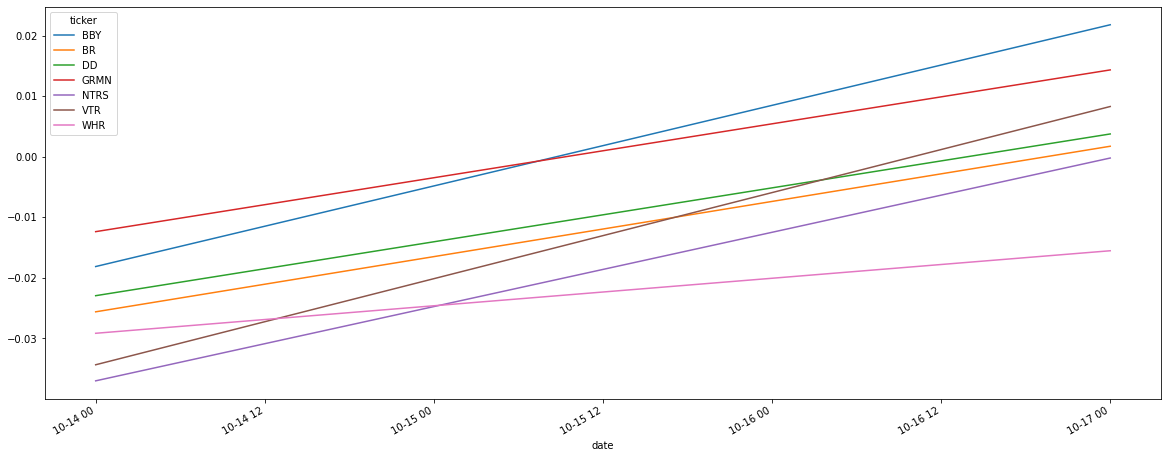

In [124]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-2:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]